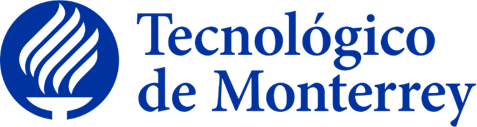

<br>

# **Actividad 3.1** 
# **Detección de Peatones con SVM**

<br>

## **MR4010 Navegación Autónoma**

<br>

**EQUIPO 13**

**Integrantes**

- Armando Bringas Corpus (A01200230).
- Juan Sebastián Téllez López(A01793859).
- Marcos Eduardo García Ortiz (A01276213).
- Carlos Enrique Díaz Ayala (A01793816).

<br>

**Docentes**

- Dr. David Antonio Torres.
- Mtra. Maricarmen Vázquez Rojí.
- Tutor Prof. Luis Ángel Lozano Medina

<br>
<br>
<br>

# **Link al video Demostrativo**

https://youtu.be/4NVZnqLsgB0

# 💻 **Librerías e instalaciones requeridas**

- **glob:** Esta librería se utiliza para encontrar todos los archivos que coincidan con un patrón especificado. En tu caso, podría estar siendo utilizada para encontrar y cargar imágenes de peatones y no peatones desde un directorio o varios directorios.

- **os:** La librería os es esencial para interactuar con el sistema operativo. Puede ser utilizada para manipular rutas de archivo, crear directorios, verificar la existencia de archivos, etc. En tu código, probablemente se use para operaciones relacionadas con archivos, como leer archivos de imágenes.

- **tarfile:** Esta librería proporciona operaciones para archivos tar, que se utilizan comúnmente para comprimir archivos y directorios en sistemas Unix. Podrías estar usando esto para extraer imágenes de un archivo tar comprimido que contiene tus conjuntos de datos.

- **cv2:** OpenCV es una librería popular para visión por computadora y procesamiento de imágenes. Es probable que la estés utilizando para cargar y preprocesar imágenes, como cambiar el tamaño, convertirlas a escala de grises, o aplicar otros filtros necesarios para la extracción de características.

- **matplotlib:** Esta librería es comúnmente usada para visualización de datos en Python. En tu código, podría ser utilizada para mostrar imágenes y gráficos, lo cual puede ser útil para la exploración de datos y la evaluación de resultados.

- **numpy:** NumPy es una librería fundamental para computación numérica en Python. Se utiliza para realizar operaciones matemáticas en matrices y arreglos multidimensionales. En el contexto de tu código, podría estar siendo utilizada para manipular y procesar los datos de imágenes.

- **requests:** Esta librería permite realizar solicitudes HTTP en Python. En tu código, podría ser utilizada para descargar imágenes de una URL si tus datos están alojados en línea.

- **seaborn:** Seaborn es una librería de visualización de datos basada en matplotlib. Se utiliza para crear gráficos estadísticos atractivos y informativos. En tu código, podría ser utilizada para visualizar la matriz de confusión u otros gráficos relacionados con la evaluación del modelo.

- **skimage:** Esta librería proporciona una colección de algoritmos para procesamiento de imágenes. En particular, el módulo skimage.feature proporciona herramientas para extracción de características, como el Histogram of Oriented Gradients (HOG), que es útil en la detección de objetos en imágenes.

- **scikit-learn:** Scikit-learn es una librería de aprendizaje automático en Python que proporciona implementaciones eficientes de una amplia gama de algoritmos de aprendizaje automático. En tu código, estás utilizando sklearn.svm para entrenar un modelo de máquina de vector de soporte (SVM) para la detección de peatones.



In [ ]:
!pip install scikit-learn-intelex

In [ ]:
!pip install scikit-image

In [ ]:
import glob
import os
import tarfile
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
from skimage.feature import hog
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

# Estas librerías son para optimizar la librería de sklearnex cuando 
# from sklearnex import patch_sklearn 
# patch_sklearn()

## 🚀 **Cargamos nuestro Dataset**

---

El dataset fue obtenido de:

http://www.gavrila.net/Datasets/Daimler_Pedestrian_Benchmark_D/Daimler_Mono_Ped__Class__Bench/daimler_mono_ped__class__bench.html

El cual contiene imagenes de Peatones y no peatones, que nos seran de mucha utilidad para el entrenamiento de nuestro modelo.

Ya que el dataset viene en formato .tar.gz, la siguiente función hace la descarga directo desde la URL y extrae las imágenes en la carpeta indicada

In [ ]:
def download_and_extract_dataset(url: str, target_dir: str):
    """
    Descarga y extrae un conjunto de datos en formato tar.gz desde una URL en el directorio especificado.

    Args:
        url (str): La URL de donde se descargará el conjunto de datos.
        target_dir (str): El directorio donde se guardará el conjunto de datos.
    """
    # Revisar que el directorio objetivo existe
    os.makedirs(target_dir, exist_ok=True)

    # Establece la ruta donde se guardará el conjunto de datos
    filename = url.split("/")[-1]
    file_path = os.path.join(target_dir, filename)

    # Verifica si el archivo ya existe
    if not os.path.exists(file_path):
        print("Descargando el conjunto de datos...")
        # Envía una solicitud GET a la URL
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            # Guarda el archivo en fragmentos para evitar usar demasiada memoria
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print("Descarga completa. Extrayendo archivos...")
            # Extrae el archivo tar.gz
            with tarfile.open(file_path, "r:gz") as tar:
                tar.extractall(path=target_dir)
            print("Extracción completa.")
        else:
            print("Fallo al descargar el archivo. Código de estado:", response.status_code)
    else:
        print("El conjunto de datos ya existe.")

Ejecución de nuestra función

In [ ]:
dataset_url = "http://www.lookingatpeople.com/data/Daimler/pami06-munder-gavrila/DC-ped-dataset_base.tar.gz"
dataset_target_dir = "data/pedestrians"

download_and_extract_dataset(dataset_url, dataset_target_dir)

Descargando el conjunto de datos...
Descarga completa. Extrayendo archivos...
Extracción completa.


# 📝 **Datos de Entrenamiento y Prueba**

De acuerdo a la descripción del dataset que viene en la siguiente página:

http://www.lookingatpeople.com/data/Daimler/pami06-munder-gavrila/README_benchmark.txt

El dataset tiene la siguiente estructura:

| **Dataset Name** | **Purpose** | **Pedestrian Labels** | **Pedestrian Examples** | **Non-ped. Examples** | **Storage Size** |
|------------------|-------------|-----------------------|-------------------------|-----------------------|------------------|
| 1                | Training    | 800                   | 4800                    | 5000                  | 39 MB            |
| 2                | Training    | 800                   | 4800                    | 5000                  | 39 MB            |
| 3                | Training    | 800                   | 4800                    | 5000                  | 39 MB            |
| T1               | Test        | 800                   | 4800                    | 5000                  | 39 MB            |
| T2               | Test        | 800                   | 4800                    | 5000                  | 39 MB            |


Obtenemos nuestros datos y explicaremos un poco sobre la función

Esta función llamada `get_data_files` se encarga de obtener una lista de archivos de datos en base a ciertos parámetros que recibe como entrada. Veamos los detalles:

- **sub_dir:** Este parámetro es una cadena que representa el subdirectorio en el que se buscarán los archivos de datos. Es el directorio específico donde se espera encontrar los archivos relevantes.

- **sub_dirs:** Este parámetro es una lista de cadenas que contiene los nombres de los subdirectorios dentro de sub_dir en los que se buscarán los archivos de datos. Esto permite buscar en varios subdirectorios dentro de sub_dir simultáneamente.

- **file_extension:** Este parámetro es una cadena que especifica la extensión de archivo de los archivos que se están buscando. Por defecto, está configurado en 'pgm'.

La función utiliza la librería glob para realizar la búsqueda de archivos en el sistema de archivos. Básicamente, `glob.glob()` devuelve una lista de nombres de archivo que coinciden con un patrón especificado.

Dentro de la función, se inicializa una lista vacía llamada `data`, que se utilizará para almacenar los nombres de los archivos encontrados.

Luego, se itera sobre cada sub_dir en `sub_dirs`. Para cada sub_dir, se utiliza `glob.glob()` para encontrar todos los archivos con la extensión especificada `(file_extension)` dentro del subdirectorio correspondiente. Estos nombres de archivo se almacenan en la variable `data_files`.

Finalmente, los nombres de archivo encontrados en data_files se agregan a la lista data utilizando el método `extend()`, que permite agregar múltiples elementos a una lista.

La función devuelve la lista `data`, que contiene los nombres de todos los archivos encontrados en los subdirectorios especificados.

In [ ]:
def get_data_files(sub_dir: str, sub_dirs: str, file_extension: str='pgm') -> list:
    data = []
    for sub_dir in sub_dirs:
        data_files = glob.glob(f"{dataset_target_dir}/{sub_dir}/*.{file_extension}")
        data.extend(data_files)
    return data

## **Datos de entrenamiento**

Archivos de entrenamiento para la clase de peatones `(pedestrians)`.

- **train_pedestrians_sub_dirs:** Es una lista que contiene los nombres de los subdirectorios donde se encuentran los ejemplos de peatones dentro del conjunto de datos de entrenamiento. Cada nombre de subdirectorio está en el formato `"número/ped_examples"`, lo que sugiere que los ejemplos de peatones están organizados en subdirectorios numerados.

- **train_pedestrians:** Esta línea de código llama a la función `get_data_files()`. Le pasa el directorio principal del conjunto de datos `(dataset_target_dir)` y la lista de subdirectorios de peatones `(train_pedestrians_sub_dirs)`. Esta función retorna una lista que contiene los nombres de todos los archivos de ejemplo de peatones encontrados en los subdirectorios especificados.

- **len(train_pedestrians):** Esto simplemente calcula la longitud de la lista `train_pedestrians`, es decir, el número total de archivos de ejemplo de peatones encontrados en los subdirectorios especificados.

Para este caso particular tenemos 14400 peatones

In [ ]:
train_pedestrians_sub_dirs = ["1/ped_examples", "2/ped_examples", "3/ped_examples"]
train_pedestrians = get_data_files(dataset_target_dir, train_pedestrians_sub_dirs)
len(train_pedestrians)

14400

Para este otro caso funciona de manera similar:

- **train_non_pedestrians_sub_dirs:** Similar al caso anterior, esta es una lista que contiene los nombres de los subdirectorios donde se encuentran los ejemplos de `no peatones` dentro del conjunto de datos de entrenamiento.

- **train_non_pedestrians:** Al igual que antes, esta línea llama a la función `get_data_files()` con el directorio principal del conjunto de datos y la lista de subdirectorios de no peatones. Esta función retorna una lista que contiene los nombres de todos los archivos de ejemplo de no peatones encontrados en los subdirectorios especificados.

- **len(train_non_pedestrians):** De nuevo, esto calcula la longitud de la lista `train_non_pedestrians`, es decir, el número total de archivos de ejemplo de no peatones encontrados en los subdirectorios especificados.

Para este caso tenemos 15000 NO peatones

In [ ]:
train_non_pedestrians_sub_dirs = ["1/non-ped_examples", "2/non-ped_examples", "3/non-ped_examples"]
train_non_pedestrians = get_data_files(dataset_target_dir, train_non_pedestrians_sub_dirs)
len(train_non_pedestrians)

15000

## **Datos de prueba**

In [ ]:
test_pedestrians_sub_dirs = ["T1/ped_examples", "T2/ped_examples"]
test_pedestrians = get_data_files(dataset_target_dir, test_pedestrians_sub_dirs)
len(test_pedestrians)

9600

In [ ]:
test_non_pedestrians_sub_dirs = ["T1/non-ped_examples", "T2/non-ped_examples"]
test_non_pedestrians = get_data_files(dataset_target_dir, test_non_pedestrians_sub_dirs)
len(test_non_pedestrians)

10000

# 👓 **Cálculo de HOG en una sola imagen**

---

Visualización de la imagen de un solo peatón mediante el uso de cv2, que detallaremos a continuación:

- `cv2.imread(train_pedestrians[170]`, `cv2.COLOR_BGR2GRAY)`: Utiliza la función `cv2.imread()` de **OpenCV** para leer una imagen del conjunto de datos de entrenamiento de peatones. `train_pedestrians[170]` proporciona la ruta del archivo de imagen específico que se va a cargar. Además, se especifica `cv2.COLOR_BGR2GRAY` como segundo argumento, que indica que la imagen se cargará en escala de grises. Esto significa que la imagen se convertirá a una representación de una sola capa `(escala de grises)` en lugar de una imagen a color. El resultado se almacena en la variable `img_pedestrian`.

- `plt.imshow(img_pedestrian, cmap='gray')`: Utiliza la función `plt.imshow()` de **Matplotlib** para mostrar la imagen cargada. `img_pedestrian` es la imagen que se mostrará. Se especifica `cmap='gray'` para indicar que la imagen debe mostrarse en escala de grises. Esto asegura que la imagen se muestre correctamente, ya que fue cargada en escala de grises en el paso anterior.

- `plt.show():` Esta línea muestra la imagen en una ventana de visualización.

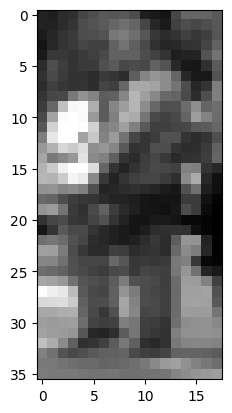

In [ ]:
img_pedestrian = cv2.imread(train_pedestrians[170], cv2.COLOR_BGR2GRAY)
plt.imshow(img_pedestrian, cmap='gray')
plt.show()

Ahora visualicemos el tamaño

In [ ]:
print(img_pedestrian.shape)

(36, 18)


Vamos a calcular el `Histogram of Oriented Gradients (HOG)` de una imagen de un peatón. Aquí está lo que cada argumento significa y cómo contribuye al cálculo de HOG:

- **img_pedestrian:** Esta es la imagen del peatón en la que se calculará el HOG. Es la imagen que has cargado previamente utilizando `OpenCV` y se ha convertido a escala de grises.

- **orientations:** Este parámetro especifica el número de contenedores de orientación en los cuales se dividirá el `ángulo de gradiente`. En este caso, se ha fijado en 10, lo que significa que el `ángulo de gradiente` se dividirá en `10 contenedores`.

- **pixels_per_cell:** Este parámetro establece el tamaño de la celda en la que se calculará el histograma de gradientes. Se especifica como una tupla de dos valores, donde el primer valor representa el número de píxeles en la dirección horizontal y el segundo valor representa el número de píxeles en la dirección vertical. En este caso, se ha establecido en `(6, 6)`, lo que significa que se utilizarán celdas de 6x6 píxeles.

- **cells_per_block:** Este parámetro establece el tamaño del bloque sobre el cual se normalizarán los histogramas de gradientes. Se especifica también como una tupla de dos valores, donde el primer valor representa el número de celdas en el bloque en la dirección horizontal y el segundo valor representa el número de celdas en el bloque en la dirección vertical. En este caso, se ha establecido en `(2, 2)`, lo que significa que se normalizarán los histogramas de gradientes sobre bloques de 2x2 celdas.

- **transform_sqrt:** Este parámetro indica si se debe aplicar una transformación de raíz cuadrada a los histogramas antes de normalizarlos. En este caso, se ha establecido en False, lo que significa que no se aplicará ninguna transformación adicional.

- **visualize:** Este parámetro especifica si se debe devolver una imagen del gradiente de orientaciones. En este caso, se ha establecido en True, lo que significa que se calculará y devolverá una imagen del gradiente de orientaciones.

- **feature_vector:** Este parámetro indica si se debe aplanar el resultado del HOG en un vector unidimensional. En este caso, se ha establecido en True, lo que significa que se devolverá el resultado del HOG como un vector unidimensional de características.

El resultado del cálculo del HOG son dos valores:

- **features:** Es el vector unidimensional de características resultante del cálculo del HOG.
- **hog_image:** Es una imagen que visualiza el gradiente de orientaciones. Esta imagen puede ser útil para visualizar cómo se están calculando las características de HOG en la imagen original.

In [ ]:
features, hog_image = hog(img_pedestrian,
                          orientations=10,
                          pixels_per_cell=(6, 6),
                          cells_per_block=(2, 2),
                          transform_sqrt= False,
                          visualize=True,
                          feature_vector=True)

In [ ]:
print(features.shape)

(400,)


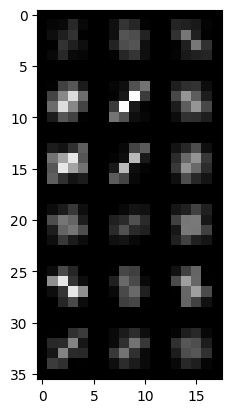

In [ ]:
plt.imshow(hog_image, cmap='gray')
plt.show()

# 🧐 **Extracción las features HOG para los datos**

---

Vamos a iniciar definiendo una función, la cual se encarga de extraer las características de Histogram of Oriented Gradients (HOG) de una lista de imágenes, y consiste en los siguientes parametros:

- **def extract_hog_features(img_data_list: list) -> list::**
 - **def:** Define una nueva función.
 - **extract_hog_features:** Es el nombre de la función.
 - **(img_data_list: list) -> list:** Especifica que la función toma una lista de datos de imagen como entrada y devuelve una lista de características de HOG.
 - **hog_data = list():** Se inicializa una lista vacía llamada hog_data. Esta lista se utilizará para almacenar las características de HOG de cada imagen procesada.

- **for img_data in img_data_list::** Este bucle itera sobre cada elemento en la lista de datos de imagen proporcionada como entrada.

- **img = cv2.imread(img_data, cv2.COLOR_BGR2GRAY):** Carga la imagen utilizando `OpenCV (cv2.imread())`. El parámetro `cv2.COLOR_BGR2GRAY` indica que la imagen se cargará en escala de grises. La imagen cargada se asigna a la variable img.

- **img_hog_feature, img_hog_image = hog(img, orientations=10, pixels_per_cell=(6, 6), cells_per_block=(2, 2), transform_sqrt= False, visualize=True, feature_vector=True):** Calcula las características de HOG de la imagen utilizando la función hog() del módulo `skimage.feature`. Los parámetros especificados son similares a los que se explicaron anteriormente. Devuelve tanto las características de HOG `(img_hog_feature)` como una imagen del gradiente de orientaciones `(img_hog_image)`.

- **hog_data.append(img_hog_feature):** Agrega las características de HOG de la imagen actual a la lista hog_data.

- **return hog_data:** Devuelve la lista hog_data, que contiene las características de HOG de todas las imágenes procesadas.

In [ ]:
def extract_hog_features(img_data_list: list) -> list:
    hog_data = list()
    for img_data in img_data_list:
        img = cv2.imread(img_data, cv2.COLOR_BGR2GRAY)
        img_hog_feature, img_hog_image = hog(img,
                                             orientations=10,
                                             pixels_per_cell=(6, 6),
                                             cells_per_block=(2, 2),
                                             transform_sqrt= False,
                                             visualize=True,
                                             feature_vector=True)
        hog_data.append(img_hog_feature)

    return hog_data

Ahora, vamos a preparar los datos de entrenamiento para el modelo de máquina de vectores de soporte (SVM) que se utilizará para la detección de peatones. Y para entender mejor el proceso, vamos a explicarlo:

- **Extracción de características HOG para peatones y no peatones:**

 - **X_train_pedestrians = np.vstack(extract_hog_features(train_pedestrians)).astype(np.float32):** Se extraen las características de HOG para las imágenes de peatones del conjunto de entrenamiento `(train_pedestrians)`. Estas características se apilan verticalmente utilizando `np.vstack()`, lo que significa que se combinan en un solo array. Se convierten a tipo `np.float32` para asegurar la precisión de los cálculos.
 - **y_train_pedestrians = np.ones(len(X_train_pedestrians)):** Se crea un array de etiquetas para las imágenes de peatones, estableciendo todas las etiquetas como `1 (indicando que son peatones)`.

- **Extracción de características HOG para no peatones:**

 - **X_train_non_pedestrians = np.vstack(extract_hog_features(train_non_pedestrians)).astype(np.float32):** Se realiza un proceso similar para las imágenes de no peatones `(train_non_pedestrians)`. Se extraen las características de HOG, se apilan verticalmente y se convierten a tipo `np.float32`.
 - **y_train_non_pedestrians = np.zeros(len(X_train_non_pedestrians)):** Se crea un array de etiquetas para las imágenes de no peatones, estableciendo todas las etiquetas como `0 (indicando que no son peatones)`.

- **Combinación de datos de peatones y no peatones:**

 - **X_train = np.vstack((X_train_pedestrians, X_train_non_pedestrians)):** Se combinan las características de HOG de peatones y no peatones en un solo array verticalmente.
 - **y_train = np.hstack((y_train_pedestrians, y_train_non_pedestrians)):** Se combinan las etiquetas de peatones y no peatones en un solo array horizontalmente.

- **Aleatorización de los datos:**

 - **random_state = np.random.RandomState(seed=42):** Se inicializa un generador de números aleatorios con una semilla fija para asegurar la reproducibilidad de los resultados.
 - **indices = random_state.permutation(len(X_train)):** Se generan índices aleatorios para los datos de entrenamiento.
 - **X_train_shuffled = X_train[indices]:** Se reorganizan los datos de características de entrenamiento aleatoriamente.
 - **y_train_shuffled = y_train[indices]:** Se reorganizan las etiquetas de entrenamiento de acuerdo con el reordenamiento de los datos de características.

In [ ]:
X_train_pedestrians = np.vstack(extract_hog_features(train_pedestrians)).astype(np.float32)
y_train_pedestrians = np.ones(len(X_train_pedestrians))

X_train_non_pedestrians = np.vstack(extract_hog_features(train_non_pedestrians)).astype(np.float32)
y_train_non_pedestrians = np.zeros(len(X_train_non_pedestrians))

X_train = np.vstack((X_train_pedestrians, X_train_non_pedestrians))
y_train = np.hstack((y_train_pedestrians, y_train_non_pedestrians))

# Poner datos de forma aleatoria
random_state = np.random.RandomState(seed=42)
indices = random_state.permutation(len(X_train))
X_train_shuffled = X_train[indices]
y_train_shuffled = y_train[indices]

Ahora vamos a eliminar las variables que contienen las etiquetas/caracteristicas del conjunto de entrenamiento

In [ ]:
del X_train
del y_train
del train_pedestrians
del train_non_pedestrians

A continuación, realizaremos la preparación para los datos de prueba, que funciona muy similar a la estructura utilizada para los datos de entrenamiento.

In [ ]:
X_test_pedestrians = np.vstack(extract_hog_features(test_pedestrians)).astype(np.float32)
y_test_pedestrians = np.ones(len(X_test_pedestrians))

X_test_non_pedestrians = np.vstack(extract_hog_features(test_non_pedestrians)).astype(np.float32)
y_test_non_pedestrians = np.zeros(len(X_test_non_pedestrians))

X_test = np.vstack((X_test_pedestrians, X_test_non_pedestrians))
y_test = np.hstack((y_test_pedestrians, y_test_non_pedestrians))

# Poner datos de forma aleatoria
indices = random_state.permutation(len(X_test))
X_test_shuffled = X_test[indices]
y_test_shuffled = y_test[indices]

Finalizamos eliminando las variables que contienen las etiquetas/caracteristicas del conjunto de prueba

In [ ]:
del X_test
del y_test
del test_pedestrians
del test_non_pedestrians

# 💪 **Modelo SVM y entrenamiento**

---

Vamos a crear y entrenar un modelo de Máquinas de Vectores de Soporte (SVC) utilizando los datos de entrenamiento aleatorizados X_train_shuffled y y_train_shuffled. Que contiene lo siguiente:

- **Creación del modelo SVC:**

 - **svc_model = SVC():** Se instancia un objeto de la clase SVC del módulo `sklearn.svm.` Por defecto, este constructor crea un modelo de SVM con un kernel RBF (función de base radial). Este modelo se utilizará para clasificar los datos de entrada en las categorías específicas `(en este caso, peatones y no peatones)`.

- **Entrenamiento del modelo:**

 - **svc_model.fit(X_train_shuffled, y_train_shuffled):** Se utiliza el método `fit()` del objeto svc_model para entrenar el modelo SVC utilizando los datos de entrenamiento aleatorizados `X_train_shuffled` como características y `y_train_shuffled` como etiquetas. Durante el entrenamiento, el modelo aprende a clasificar los datos de entrada en las categorías especificadas `(1 para peatones y 0 para no peatones)` utilizando el algoritmo de Máquinas de Vectores de Soporte.

In [ ]:
svc_model = SVC()
svc_model.fit(X_train_shuffled, y_train_shuffled)

SVC()

Ahora vamos a hacer predicciones sobre los datos de prueba aleatorizados X_test_shuffled:

- **y_pred = svc_model.predict(X_test_shuffled):** Se utiliza el método `predict()` del modelo svc_model para realizar predicciones sobre las características de prueba aleatorizadas `X_test_shuffled`. Este método toma las características de prueba como entrada y devuelve las etiquetas predichas para esas características.

In [ ]:
y_pred = svc_model.predict(X_test_shuffled)

In [ ]:
# Guardar el modelo resultante
joblib.dump(svc_model, 'svc_model.pkl')

['svc_model.pkl']

# 🔎 **Validación de métricas del modelo**

---

Vamos a generar una matriz de confusión y la visualizaremos como un mapa de calor utilizando la biblioteca Seaborn y Matplotlib, de la siguiente manera:

- **cm = confusion_matrix(y_test_shuffled, y_pred, labels=[0, 1]):** Se calcula la matriz de confusión utilizando la función `confusion_matrix()` de `Scikit-learn`. Esta matriz compara las etiquetas verdaderas `y_test_shuffled` con las etiquetas predichas `y_pred`. La matriz de confusión es una herramienta que muestra **la cantidad de predicciones correctas e incorrectas del modelo** para cada clase `(en este caso, 0 para no peatones y 1 para peatones)`. Los parámetros `labels=[0, 1]` se utilizan para especificar el orden de las etiquetas en la matriz de confusión.

- **sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False):** Se utiliza la función `heatmap()` de Seaborn para visualizar la matriz de confusión cm como un mapa de calor. Los parámetros utilizados son:

 - **cm:** La matriz de confusión a visualizar.
 - **annot=True:** Se añaden anotaciones a las celdas del mapa de calor para mostrar los valores de la matriz de confusión.
 - **fmt='g':** El formato de las anotaciones se establece en formato general.
 - **cmap='Purples':** Se utiliza el esquema de color 'Purples' para el mapa de calor, que es una paleta de colores que va desde tonos claros a oscuros de púrpura.
 - **cbar=False:** Se desactiva la barra de color lateral en el mapa de calor.
 - **plt.show():** Muestra el mapa de calor generado utilizando la función show() de Matplotlib.

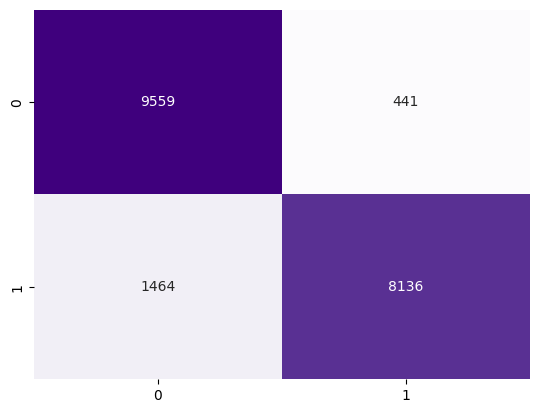

In [ ]:
cm = confusion_matrix(y_test_shuffled, y_pred, labels=[0, 1])
sns.heatmap(cm,  annot=True, fmt='g', cmap='Purples', cbar=False)
plt.show()

- **Verdaderos negativos (TN): 9559**

 Estos son los casos en los que el modelo predijo correctamente que las muestras no pertenecían a la clase de peatones (clase negativa).

- **Falsos positivos (FP): 441**

 Estos son los casos en los que el modelo predijo incorrectamente que las muestras pertenecían a la clase de peatones cuando en realidad no lo eran. Es decir, el modelo dio un resultado positivo cuando la verdad era negativa.

- **Falsos negativos (FN): 1464**

 Estos son los casos en los que el modelo predijo incorrectamente que las muestras no pertenecían a la clase de peatones cuando en realidad sí lo eran. Es decir, el modelo dio un resultado negativo cuando la verdad era positiva.

- **Verdaderos positivos (TP): 8136**

 Estos son los casos en los que el modelo predijo correctamente que las muestras pertenecían a la clase de peatones (clase positiva).

Entonces, para interpretar estos resultados:

- El modelo clasificó correctamente `9559` muestras como `no peatones`.
- El modelo clasificó incorrectamente `441` muestras como `peatones` cuando en realidad `no lo eran`.
- El modelo clasificó incorrectamente `1464` muestras como `no peatones` cuando en realidad `sí lo eran`.
- El modelo clasificó correctamente `8136` muestras como `peatones`.

In [ ]:
print(cm)

[[9559  441]
 [1464 8136]]


In [ ]:
print(classification_report(y_test_shuffled, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     10000
         1.0       0.95      0.85      0.90      9600

    accuracy                           0.90     19600
   macro avg       0.91      0.90      0.90     19600
weighted avg       0.91      0.90      0.90     19600



Estas métricas proporcionan una evaluación detallada del rendimiento del modelo en términos de precisión, exhaustividad (recall), puntuación F1 y precisión ponderada (weighted average).

- **Precision (Precisión):** Es la proporción de casos positivos clasificados correctamente entre todos los casos clasificados como positivos. Para la clase `0 (no peatones)`, la precisión es `0.87`, lo que significa que el `87%` de las muestras clasificadas como **no peatones son realmente no peatones**. Para la `clase 1 (peatones)`, la precisión es `0.95`, lo que significa que el `95%` de las muestras clasificadas como **peatones son realmente peatones**.

- **Recall (Exhaustividad):** Es la proporción de casos positivos clasificados correctamente entre todos los casos que son realmente positivos. Para la clase `0`, la exhaustividad es `0.96`, lo que significa que el `96%` de las muestras de no peatones fueron identificadas correctamente como no peatones. Para la clase `1`, la exhaustividad es `0.85`, lo que significa que el `85%` de las muestras de peatones fueron identificadas correctamente como peatones.

- **F1-score (Puntuación F1):** Es la media armónica de la precisión y la exhaustividad. Representa la precisión ponderada y la exhaustividad del modelo en una sola métrica. Para la clase 0, el F1-score es 0.91, y para la clase 1, es 0.90.

- **Accuracy (Exactitud):** Es la proporción de muestras clasificadas correctamente entre todas las muestras. En este caso, la exactitud es `0.90`, lo que significa que el `90%` de todas las muestras fueron clasificadas correctamente por el modelo.

- **Support (Soporte):** Es el número de ocurrencias reales de cada clase en el conjunto de datos de prueba. Para la clase `0 (no peatones)`, el soporte es 10000, lo que indica que hay 10000 muestras en el conjunto de datos de prueba que pertenecen a la clase de no peatones. Para la clase `1 (peatones)`, el soporte es 9600, lo que indica que hay 9600 muestras en el conjunto de datos de prueba que pertenecen a la clase de peatones.

- **Macro avg (Media macro):** Es el promedio simple de las métricas para todas las clases. En este caso, es el promedio de precisión, exhaustividad y puntuación F1 para ambas clases.

- **Weighted avg (Media ponderada):` Es el promedio ponderado de las métricas para todas las clases, donde el peso es el soporte de cada clase. En este caso, es el promedio ponderado de precisión, exhaustividad y puntuación F1 para ambas clases, utilizando el soporte de cada clase como peso.

# 📈 **Grid Search**

---

A continuación, este bloque de código define un diccionario llamado param_grid que contiene una cuadrícula de `hiperparámetros` para ser explorados durante la búsqueda de `hiperparámetros` mediante `validación cruzada` en el proceso de ajuste del modelo de Máquinas de Vectores de Soporte (SVM).

- **'C':** Este parámetro controla la penalización por error de clasificación. Un valor más pequeño de C implica una regularización más fuerte, lo que lleva a una frontera de decisión más suave. Los valores especificados son [1, 10, 100, 1000], lo que indica que la búsqueda de hiperparámetros probará estos valores para el parámetro C.

- **'gamma':** Este parámetro controla el ancho del kernel Gaussiano. Un valor más pequeño de gamma significa que el radio de influencia de los ejemplos de entrenamiento es más grande, lo que lleva a una frontera de decisión más suave y menos compleja. Los valores especificados son [0.0001, 0.001, 0.01, 0.1, 1], lo que indica que la búsqueda de hiperparámetros probará estos valores para el parámetro gamma.

- **'kernel':** Este parámetro especifica el tipo de kernel a utilizar en el modelo SVM. En este caso, se utiliza el kernel radial (RBF), que es uno de los más comúnmente utilizados en SVM. El valor especificado es `['rbf']`, lo que indica que solo se probará el kernel radial durante la búsqueda de hiperparámetros.

In [ ]:
param_grid = {'C': [1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1], 'kernel': ['rbf']}

Ahora, vamos a realizar una búsqueda exhaustiva de hiperparámetros utilizando validación cruzada `(cross-validation)` para encontrar la mejor combinación de hiperparámetros para el modelo de Máquinas de Vectores de Soporte (SVC).

**GridSearchCV(SVC(), param_grid, refit=True, verbose=4):**

 - **SVC():** Este es el estimador sobre el cual se realiza la búsqueda de hiperparámetros. En este caso, se utiliza `SVC()` para un modelo de Máquinas de Vectores de Soporte (SVM).
 - **param_grid:** Este es el diccionario que contiene la cuadrícula de hiperparámetros a explorar. Se define anteriormente y contiene combinaciones de valores para los hiperparámetros C, gamma, y kernel.
 - **refit=True:** Este parámetro indica que se ajustará el mejor estimador encontrado con los mejores hiperparámetros a todo el conjunto de datos de entrenamiento una vez que finalice la búsqueda.
 - **verbose=4:** Este parámetro controla el nivel de verbosidad de la salida durante el proceso de ajuste. Un valor de 4 indica que se imprimirá un mensaje para cada combinación de hiperparámetros durante la búsqueda.

**grid_search.fit(X_train_shuffled, y_train_shuffled):**

 Este método inicia el proceso de búsqueda de hiperparámetros y ajusta el modelo a los datos de entrenamiento aleatorizados (X_train_shuffled y y_train_shuffled) utilizando validación cruzada.

En cuanto al tiempo de ejecución, es difícil dar una estimación precisa sin conocer el tamaño de los datos y la complejidad del modelo. Sin embargo, la búsqueda exhaustiva de hiperparámetros puede ser computacionalmente costosa, especialmente con un gran número de combinaciones de hiperparámetros y un conjunto de datos grande. El tiempo de ejecución también dependerá de la capacidad de procesamiento de tu hardware. En este caso, dado que la búsqueda exhaustiva implica probar múltiples combinaciones de hiperparámetros y ajustar el modelo para cada una de ellas, es posible que el tiempo de ejecución sea largo.

In [ ]:
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=4)
grid_search.fit(X_train_shuffled, y_train_shuffled)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.554 total time= 3.4min
[CV 2/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.550 total time= 3.5min
[CV 3/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.554 total time= 3.5min
[CV 4/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.550 total time= 3.5min
[CV 5/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.548 total time= 3.4min
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.864 total time= 2.6min
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.855 total time= 2.6min
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.848 total time= 2.6min
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.856 total time= 2.6min
[CV 5/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.853 total time= 2.5min
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.896 total time= 1.6min
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             verbose=4)

Después de completar la búsqueda exhaustiva de hiperparámetros utilizando validación cruzada, el atributo `best_params_` de grid_search contiene un diccionario que especifica los mejores hiperparámetros encontrados durante el proceso de búsqueda.

**grid_search.best_params_:** Este atributo devuelve un diccionario que contiene los mejores valores de los hiperparámetros encontrados durante la búsqueda exhaustiva. Cada clave del diccionario corresponde a un hiperparámetro y su valor es la mejor opción encontrada para ese hiperparámetro.

Para nuestro caso específico, los mejores hiperparámetros encontrados son:

- `**C: 100**`
- `**gamma: 0.1**`
- `**kernel: 'rbf'**`

Esto indica que, según los resultados de la búsqueda de hiperparámetros, el modelo de `Máquinas de Vectores de Soporte (SVM)` alcanza el mejor rendimiento cuando se entrena con un parámetro de regularización C igual a 100, un parámetro de ancho de kernel gamma igual a 0.1, y utilizando un kernel radial ('rbf'). Estos son los valores óptimos encontrados que maximizan el rendimiento del modelo en el conjunto de datos de entrenamiento durante la búsqueda de hiperparámetros.

In [ ]:
grid_search.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [ ]:
grid_search.best_estimator_

SVC(C=100, gamma=0.1)

Vamos a utilizar el modelo de SVM con los mejores hiperparámetros encontrados durante la búsqueda exhaustiva de hiperparámetros `(grid_search)` para hacer predicciones sobre el conjunto de datos de prueba aleatorizado `(X_test_shuffled)`.

In [ ]:
grid_predictions = grid_search.predict(X_test_shuffled)

Generamos nuestra matriz de confusión

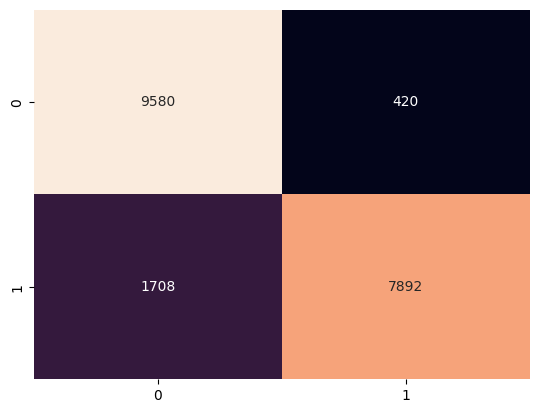

In [ ]:
cm = confusion_matrix(y_test_shuffled, grid_predictions)
sns.heatmap(cm, annot=True, fmt='g', cbar=False)
plt.show()

In [ ]:
cm

array([[9580,  420],
       [1708, 7892]], dtype=int64)

Comparando las dos matrices de confusión, podemos observar los siguientes cambios:

**Antes de la búsqueda de hiperparámetros:**

- Verdaderos negativos (TN): `9559`
- Falsos positivos (FP): `441`
- Falsos negativos (FN): `1464`
- Verdaderos positivos (TP): `8136`

**Después de la búsqueda de hiperparámetros:**

- Verdaderos negativos (TN): `9580`
- Falsos positivos (FP): `420`
- Falsos negativos (FN): `1708`
- Verdaderos positivos (TP): `7892`

**Observaciones:**

- Se observa una ligera mejora en los verdaderos negativos (TN), aumentando de 9559 a 9580.
- Se produce una reducción en los falsos positivos (FP), disminuyendo de 441 a 420.
- Hay un aumento en los falsos negativos (FN), incrementando de 1464 a 1708.
- Se observa una disminución en los verdaderos positivos (TP), bajando de 8136 a 7892.

Por lo tanto, después de aplicar la búsqueda de hiperparámetros, el modelo tiende a clasificar correctamente más muestras como no peatones (aumento en los verdaderos negativos) y menos muestras como falsos positivos (disminución en los falsos positivos). Sin embargo, también hay un aumento en los falsos negativos, lo que indica que el modelo clasifica incorrectamente más muestras como no peatones cuando en realidad son peatones. Esto sugiere que el ajuste de los hiperparámetros ha tenido un impacto en la capacidad del modelo para generalizar, pero aún pueden ser necesarios ajustes adicionales para mejorar el rendimiento en términos de clasificación de peatones.

In [ ]:
print(classification_report(y_test_shuffled, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90     10000
         1.0       0.95      0.82      0.88      9600

    accuracy                           0.89     19600
   macro avg       0.90      0.89      0.89     19600
weighted avg       0.90      0.89      0.89     19600



**Antes de la búsqueda de hiperparámetros:**

- Precision (Precisión) para la clase 0 (no peatones): `0.87`
- Recall (Exhaustividad) para la clase 0: `0.96`
- F1-score (Puntuación F1) para la clase 0: `0.91`
- Precision para la clase 1 (peatones): `0.95`
- Recall para la clase 1: `0.85`
- F1-score para la clase 1: `0.90`
- Exactitud (Accuracy): `0.90`

**Después de la búsqueda de hiperparámetros:**

- Precision para la clase 0 (no peatones): `0.85`
- Recall para la clase 0: `0.96`
- F1-score para la clase 0: `0.90`
- Precision para la clase 1 (peatones): `0.95`
- Recall para la clase 1: `0.82`
- F1-score para la clase 1: `0.88`
- Exactitud (Accuracy): `0.89`

**Observaciones:**

- Después de la búsqueda de hiperparámetros, observamos una disminución en el recall para la clase 1 (peatones), pasando de 0.85 a 0.82.
- También vemos una ligera disminución en la precisión para la clase 0 (no peatones), de 0.87 a 0.85.
- El F1-score para la clase 0 permanece relativamente estable, disminuyendo solo ligeramente de 0.91 a 0.90.
- El F1-score para la clase 1 muestra una disminución más notable, de 0.90 a 0.88.
- La exactitud general del modelo disminuye ligeramente de 0.90 a 0.89 después de la búsqueda de hiperparámetros.

Por lo tanto, tendremos como opción inicial el primer modelo entrenado, que tiene un mayor balance respecto a la calidad de las predicciones.

In [ ]:
import joblib

# Guardar el modelo resultante
joblib.dump(grid_search, 'modelo_entrenado.pkl')

# Realizar predicciones con el modelo y guardarlas
grid_predictions = grid_search.predict(X_test_shuffled)
joblib.dump(grid_predictions, 'predicciones.pkl')

['predicciones.pkl']

Con esta ultima linea, guardamos nuestro modelo para que pueda ser utilizado más adelante para generar predicciones.

In [ ]:
# Cargar el modelo
modelo_cargado = joblib.load('modelo_entrenado.pkl')

# Cargar las predicciones
predicciones_cargadas = joblib.load('predicciones.pkl')